<a href="https://colab.research.google.com/github/piru24/DL_Ass_Sample/blob/main/IT22358820_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===============================
# Step 0: Import Libraries
# ===============================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# ===============================
# Step 1: Load and Clean Dataset
# ===============================
df = pd.read_csv("IMDB Dataset.csv", escapechar='\\', engine='python', on_bad_lines='skip')
df = df.dropna(subset=['review', 'sentiment']).drop_duplicates(subset='review')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print("Cleaned Dataset shape:", df.shape)

# ===============================
# Step 2: Text Cleaning + Lemmatization
# ===============================
stop_words = set(stopwords.words('english')) - {"not", "no", "nor"}  # keep sentiment words
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)       # remove HTML
    text = re.sub(r"http\S+|www\S+", " ", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)   # keep only alphabets
    text = text.lower()
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return " ".join(words)

df['review'] = df['review'].apply(clean_text)
print("Sample cleaned review:\n", df['review'].iloc[0])


Cleaned Dataset shape: (14971, 2)
Sample cleaned review:
 one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull no punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate t

In [4]:
# ===============================
# Step 3: Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)


In [5]:
# ===============================
# Step 4: Tokenization + Padding
# ===============================
NUM_WORDS = 20000
MAXLEN = 300

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN)

print("Vocabulary size:", len(tokenizer.word_index))


Vocabulary size: 49705


In [7]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

# Unzip the file
!unzip glove.6B.zip

# Confirm it's available
!ls -lh glove.6B.300d.txt

--2025-10-10 12:16:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-10-10 12:16:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-10-10 12:16:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [8]:
# ===============================
# Step 5: Load Pretrained GloVe Embeddings
# ===============================
embedding_dim = 300
embeddings_index = {}
glove_path = "/content/glove.6B.300d.txt"  # download from

with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coef

embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < NUM_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("GloVe Embedding matrix shape:", embedding_matrix.shape)


GloVe Embedding matrix shape: (20000, 300)


In [9]:
# ===============================
# Step 6: Build BiLSTM Model with Regularization
# ===============================
model = Sequential([
    Embedding(input_dim=NUM_WORDS,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=MAXLEN,
              trainable=False),  # freeze pretrained embeddings

    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,000 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,000 (22.89 MB)

In [10]:
# ===============================
# Step 7: Train Model (with EarlyStopping & LR Scheduler)
# ===============================
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.5415 - loss: 0.7712 - val_accuracy: 0.7137 - val_loss: 0.6745 - learning_rate: 1.0000e-04
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.7086 - loss: 0.6564 - val_accuracy: 0.7579 - val_loss: 0.5669 - learning_rate: 1.0000e-04
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 463s 3s/step - accuracy: 0.7497 - loss: 0.5890 - val_accuracy: 0.7905 - val_loss: 0.5048 - learning_rate: 1.0000e-04
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.7640 - loss: 0.5523 - val_accuracy: 0.7963 - val_loss: 0.4892 - learning_rate: 1.0000e-04
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 486s 3s/step - accuracy: 0.7757 - loss: 0.5362 - val_accuracy: 0.8147 - val_loss: 0.4655 - learning_rate: 1.0000e-04
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.7829 - loss: 0.5200 - val_accuracy: 0.8180 - val_loss: 0.4609 - learning_rate: 1.0000e-04
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - acc

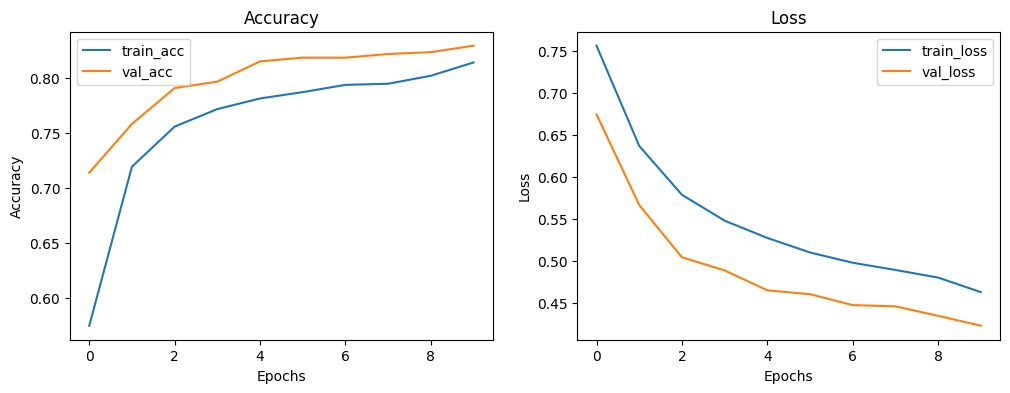

In [11]:
# ===============================
# Step 7: Plot Training History
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 322ms/step - accuracy: 0.8363 - loss: 0.4262
Test Accuracy: 0.8407
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 390ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1528
           1       0.83      0.85      0.84      1467

    accuracy                           0.84      2995
   macro avg       0.84      0.84      0.84      2995
weighted avg       0.84      0.84      0.84      2995



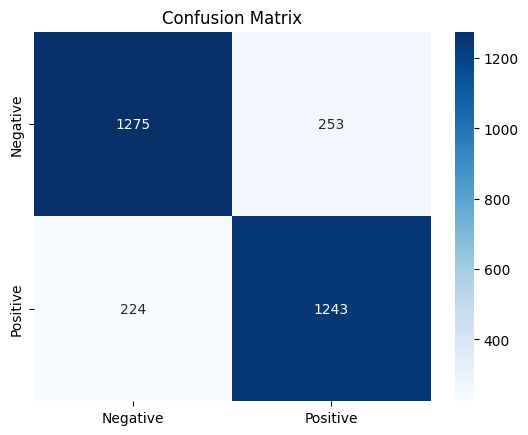

In [12]:
# ===============================
# Step 8: Evaluate Model
# ===============================
loss, acc = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Accuracy: {acc:.4f}")

# Predict and Report
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.show()

In [13]:
# ===============================
# Step 9: Custom Review Prediction
# ===============================
def predict_review(review_text):
    text = clean_text(review_text)
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAXLEN)
    pred_prob = model.predict(pad)[0][0]
    label = "Positive" if pred_prob > 0.5 else "Negative"
    return label, pred_prob

review = "The movie was outstanding and emotionally powerful!"
print(predict_review(review))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
('Positive', np.float32(0.8592534))


In [14]:
# ===============================
# Step 9: Predict Custom Reviews
# ===============================
def predict_review(review_text):
    text = re.sub(r"<.*?>", " ", review_text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()

    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=MAXLEN)
    pred_prob = model.predict(pad)[0][0]
    label = "Positive" if pred_prob > 0.5 else "Negative"

    return label, pred_prob

# Example 1
review = "The movie was amazing! I loved the acting and the storyline."
label, prob = predict_review(review)
print(f"Predicted Sentiment: {label} (Probability: {prob:.2f})")

# Example 2
review = "I did not enjoy this movie at all. It was boring and too long."
label, prob = predict_review(review)
print(f"Predicted Sentiment: {label} (Probability: {prob:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Predicted Sentiment: Positive (Probability: 0.85)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Predicted Sentiment: Negative (Probability: 0.32)
